In [1]:
# Setup notebook
from pathlib import Path
from learntools.time_series.style import *  # plot style settings
from learntools.time_series.utils import (create_multistep_example,
                                          load_multistep_data,
                                          make_lags,
                                          make_multistep_target,
                                          plot_multistep)
from learntools.time_series.utils import plot_periodogram, seasonal_plot

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import RegressorChain
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor

In [2]:
comp_dir = Path('../input/store-sales-time-series-forecasting')

store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = store_sales.groupby('date').mean()['sales']

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean()
    .unstack('family')
    .loc['2017']
)

test = pd.read_csv(
    comp_dir / 'test.csv',
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
test['date'] = test.date.dt.to_period('D')
test = test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [3]:
# This class creates a Hybrid model with two given models
class BoostedHybrid:
    def __init__(self, model_1, model_2):
        self.model_1 = model_1
        self.model_2 = model_2
        self.y_columns = None  # store column names from fit method

In [4]:
def fit(self, X_1, X_2, y):
    # fitting self.model_1
    self.model_1.fit(X_1,y)

    y_fit = pd.DataFrame(
        # making predictions with self.model_1
        self.model_1.predict(X_1),
        index=X_1.index, columns=y.columns,
    )

    # computing residuals
    y_resid = y - y_fit
    y_resid = y_resid.stack().squeeze() # wide to long

    # fitting self.model_2 on residuals
    self.model_2.fit(X_2, y_resid)
    
    # Saving column names for predict method
    self.y_columns = y.columns
    # Saving data for question checking
    self.y_fit = y_fit
    self.y_resid = y_resid

# Add method to class
BoostedHybrid.fit = fit

In [5]:
def predict(self, X_1, X_2):
    y_pred = pd.DataFrame(
        # predicting with self.model_1
        self.model_1.predict(X_1),
        index=X_1.index, columns=self.y_columns,
    )
    y_pred = y_pred.stack().squeeze()  # wide to long format of data representation

    # adding self.model_2 predictions to y_pred
    y_pred += self.model_2.predict(X_2)
    
    return y_pred.unstack()  # long to wide


# Adding method to class
BoostedHybrid.predict = predict

In [6]:
#looking at the time indexes of the training and the test datasets 
#to identify the forecasting task
print("Training Data", "\n" + "-" * 13 + "\n", store_sales)
print("\n")
print("Test Data", "\n" + "-" * 9 + "\n", test)

Training Data 
-------------
                                      sales  onpromotion
store_nbr family     date                              
1         AUTOMOTIVE 2013-01-01   0.000000            0
                     2013-01-02   2.000000            0
                     2013-01-03   3.000000            0
                     2013-01-04   3.000000            0
                     2013-01-05   5.000000            0
...                                    ...          ...
9         SEAFOOD    2017-08-11  23.830999            0
                     2017-08-12  16.859001            4
                     2017-08-13  20.000000            0
                     2017-08-14  17.000000            0
                     2017-08-15  16.000000            0

[3000888 rows x 2 columns]


Test Data 
---------
                                       id  onpromotion
store_nbr family     date                            
1         AUTOMOTIVE 2017-08-16  3000888            0
                     2017-08

To gain some insights on the average sales, I will try to detrend and deseasonalize the 
average sales time series using the MARS(Multivariate Adaptive Regression Splines) algorithm from the pyearth library and Fourier Features respectively.

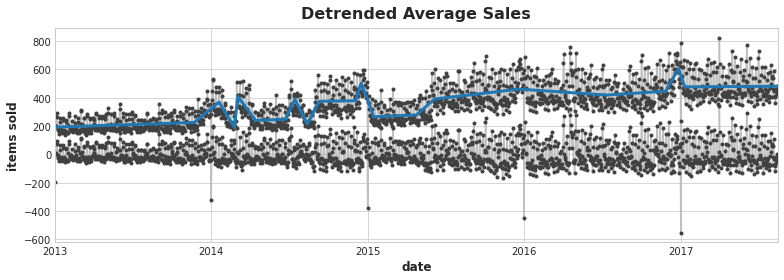

In [7]:
#This block is used for determining the trend of average sales and detrending
from pyearth import Earth

# Target and features are the same as before
y = average_sales.copy()
dp1 = DeterministicProcess(index=y.index, order=1)
X = dp1.in_sample()

# Fit a MARS model with `Earth`
model = Earth()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(**plot_params, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend")

y_detrended = y - y_pred   # remove the trend from store_sales

y_detrended.plot(**plot_params, title="Detrended Average Sales");

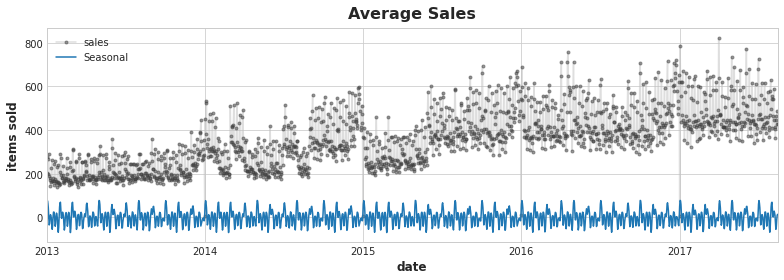

In [8]:
#This block is useful for detect seasonality in the average sales time series

fourier = CalendarFourier(freq="M",order=4)
dp2 = DeterministicProcess(
    index=y_detrended.index,
    constant=True,
    order=1,
    # YOUR CODE HERE
    seasonal=True,   #indicators for weekly seasons 
    additional_terms=[fourier],  #monthly seasonality using Fourier features
    drop=True,
)
X = dp2.in_sample()

model = LinearRegression().fit(X, y_detrended)

y_pred = pd.Series(model.predict(X), index=X.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

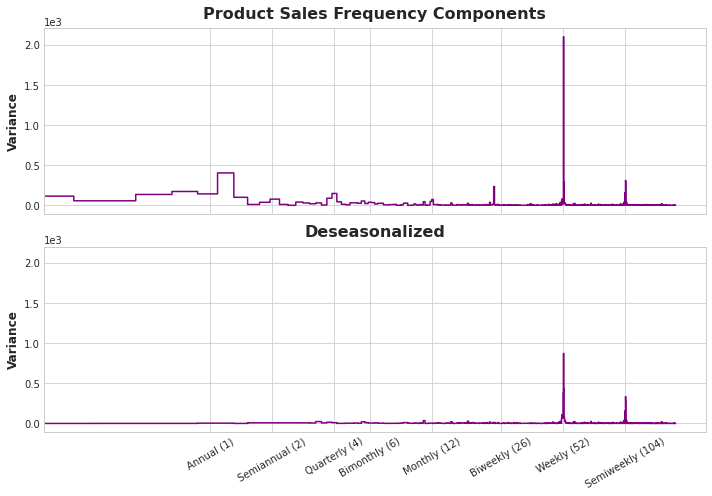

In [9]:
y_deseason = y_detrended - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

In [10]:
# Here, the forecasting horizon is 16 
# selecting the target
y = family_sales.loc[:, 'sales']

# Making 4 lag features
X = make_lags(y,lags=4).dropna()

# Making multistep target
y = make_multistep_target(y,steps=16).dropna()

y, X = y.align(X, join='inner', axis=0)

In [11]:
# X_1: Features for Linear Regression
#dp = DeterministicProcess(index=y.index, order=1)
#X_1 = dp.in_sample()


# X_2: Features for XGBoost
#X_2 = family_sales.drop('sales', axis=1).stack()  # onpromotion feature

# Label encoding for 'family'
#le = LabelEncoder()  # from sklearn.preprocessing
#X_2 = X_2.reset_index('family')
#X_2['family'] = le.fit_transform(X_2['family'])

# Label encoding for seasonality
#X_2["day"] = X_2.index.day  # values are day of the month

In [12]:
le = LabelEncoder()
X = (X
    .stack('family')  # wide to long
    .reset_index('family')  # convert index to column
    .assign(family=lambda x: le.fit_transform(x.family))  # label encode
)
y = y.stack('family')  # wide to long

display(y)

y_step_1     y_step_2     y_step_3  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     6.333333     6.018518    10.259259   
           BABY CARE                      0.351852     0.277778     0.259259   
           BEAUTY                         5.925926     6.518518    10.037037   
           BEVERAGES                   3258.796387  3507.277832  4848.518555   
           BOOKS                          0.407407     0.537037     0.481481   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      364.955658   403.601349   377.313965   
           PREPARED FOODS                84.698647    87.836800    88.735962   
           PRODUCE                     2257.140625  2609.180176  3122.895752   
           SCHOOL AND OFFICE SUPPLIES    30.111111    49.333332    57.481480   
           SEAFOOD                       20.488333    20.346851    20.801037   

                                          y_step_4     y_step_5     y_step_6  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     9.388889     5.944445     4.777778   
           BABY CARE                      0.240741     0.444444     0.240741   
           BEAUTY                        11.611111     5.648148     6.500000   
           BEVERAGES                   5503.647949  3448.203613  3171.740723   
           BOOKS                          0.722222     0.500000     0.518519   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      316.436096   533.497070   416.454010   
           PREPARED FOODS                77.172997    91.886757   100.384964   
           PRODUCE                     1792.220947  2079.319580  2418.970215   
           SCHOOL AND OFFICE SUPPLIES    51.907406    63.222221    85.203705   
           SEAFOOD                       17.116297    25.553963    24.209518   

                                          y_step_7     y_step_8     y_step_9  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     6.314815     5.388889     5.240741   
           BABY CARE                      0.277778     0.296296     0.296296   
           BEAUTY                         5.277778     4.370370     4.703704   
           BEVERAGES                   3046.870361  2693.722168  3226.037109   
           BOOKS                          0.481481     0.388889     0.444444   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      464.596558   344.051727   313.780884   
           PREPARED FOODS               102.248146    86.627441    77.344131   
           PRODUCE                     2675.105713  2111.133545  2168.535400   
           SCHOOL AND OFFICE SUPPLIES   100.277779    64.407410    59.759258   
           SEAFOOD                       23.512852    18.419851    18.481131   

                                         y_step_10    y_step_11    y_step_12  \
date       family                                                              
2017-01-05 AUTOMOTIVE                     8.500000    10.259259     6.407407   
           BABY CARE                      0.388889     0.425926     0.314815   
           BEAUTY                         7.777778     9.037037     5.648148   
           BEVERAGES                   4667.296387  5580.611328  3700.370361   
           BOOKS                          0.574074     0.555556     0.388889   
...                                            ...          ...          ...   
2017-07-31 POULTRY                      305.270203   278.819855   468.857361   
           PREPARED FOODS                84.796539    78.791443    96.286926   
           PRODUCE                     2663.076172  1670.264893  2198.854492   
           SCHOOL AND OFFICE SUPPLIES  

In [13]:
# X_1: Features for Linear Regression
dp = DeterministicProcess(index=y.index, order=1)
X_1 = dp.in_sample()


# X_2: Features for XGBoost
X_2 = family_sales.drop('sales', axis=1).stack()  # onpromotion feature

# Label encoding for 'family'
le2 = LabelEncoder()  # from sklearn.preprocessing
X_2 = X_2.reset_index('family')
X_2['family'] = le2.fit_transform(X_2['family'])

# Label encoding for seasonality
X_2["day"] = X_2.index.day  # values are day of the month

In [14]:
# Creating LinearRegression + XGBRegressor hybrid with BoostedHybrid
#model_2 = RegressorChain(XGBRegressor())
#model = BoostedHybrid(LinearRegression(),model_2)

# Fit and predict
#model.fit(X_1, X_2, y)
#y_pred = model.predict(X_1, X_2)
#y_pred = y_pred.clip(0.0)

#model.fit(X, y)

#y_pred = pd.DataFrame(
#    model.predict(X),
#    index=y.index,
#    columns=y.columns,
#).clip(0.0)

In [15]:
#FAMILY = 'BEAUTY'
#START = '2017-04-01'
#EVERY = 16

#y_pred_ = y_pred.xs(FAMILY, level='family', axis=0).loc[START:]
#y_ = family_sales.loc[START:, 'sales'].loc[:, FAMILY]

#fig, ax = plt.subplots(1, 1, figsize=(11, 4))
#ax = y_.plot(**plot_params, ax=ax, alpha=0.5)
#ax = plot_multistep(y_pred_, ax=ax, every=EVERY)
#_ = ax.legend([FAMILY, FAMILY + ' Forecast'])

In [16]:
#ypred=pd.DataFrame(model.predict(test),index=test.index,columns=y.columns).clip(0.)
#sub = pd.read_csv('../input/store-sales-time-series-forecasting/sample_submission.csv')
#sub['sales'] = ypred.values
#sub.to_csv('submission.csv', index = False)